### First preprocessing approaches, now parallelized preprocessing scripts in the /scripts folder

### Imports

In [2]:
from util.data_util import *
import pandas as pd
from datetime import datetime

OPENSLIDE_PATH = "C:\\Users\\peter\/Documents\\Uni\\Second_Year\\MDP\\Openslide\\openslide-bin-4.0.0.3-windows-x64\\bin"
#with os.add_dll_directory(OPENSLIDE_PATH):
import openslide
import ntpath
ntpath.realpath = ntpath.abspath

Assuming we have locally the dataset CPTAC-PDA from
https://www.cancerimagingarchive.net/collection/cptac-pda/
And the annotations from
https://portal.gdc.cancer.gov/projects/CPTAC-3

## Preprocess the CT scans with class balancing

In [15]:
#We choose volumes with an associated segmentation or seed point because this implicitly implies that the volume is showing a tumor

root_path = os.path.normpath('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()] #Get patients folders
annotations = pd.read_csv('./data/clinical_annotations.tsv',  sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
metadata = pd.read_csv('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/metadata.csv')

#Let's calculate volume dimension per class to get balanced dataset 
# Get class frequencies
freq_dict = {"G1":0, "G2":0, "G3":0}
total = 0
for subfolder in subfolders:
    patient_id = subfolder.split('\\')[-1]
    cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
    freq_dict[cancer_grade] += 1
    total +=1

print(freq_dict)
print(max(freq_dict.values()))
target_shape = {}
for index in freq_dict.keys():
    target_shape[index] = [int((total/len(freq_dict) ) * max(freq_dict.values()) / freq_dict[index]), 244, 244]
    
print(target_shape)


{'G1': 5, 'G2': 33, 'G3': 19}
33
{'G1': [125, 244, 244], 'G2': [19, 244, 244], 'G3': [33, 244, 244]}


In [3]:
target_depths = {"G1":140, "G2":16, "G3":46}
root_path = os.path.normpath('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA')
segmentation_root = os.path.normpath('./data/raw/Segmentations/')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()] #Get patients folders
annotations = pd.read_csv('./data/clinical_annotations.tsv',  sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
segmentations_metadata = pd.read_csv('./data/raw/Segmentations/metadata.csv')
metadata = pd.read_csv('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/metadata.csv')
target_shape = [224,224,224]
# Since the volumes are put in subfolders of patient's folders (and I'm still not sure about which of the 
# volume subfolders I should choose) I choose the first subfolder of the patient as the volume to be 
# preprocessed.
segmentations = segmentations.set_index("SeriesInstanceUID").join(segmentations_metadata.set_index("Series UID")["File Location"], how = "inner")
segmentations = segmentations[segmentations["Annotation Type"] == "Segmentation"]

#print(segmentations.head())         
with open("data/processed/labels.txt","w") as labels_f:
    for index, row in segmentations.iterrows():
        referenced_series_instance_uid = row["ReferencedSeriesInstanceUID"]
        
        volume_folder = metadata[metadata["Series UID"]==referenced_series_instance_uid]["File Location"]
        if volume_folder.empty:
            continue
        volume_folder = volume_folder.iloc[0]
        volume_folder = os.path.join(root_path,os.path.join(*(volume_folder.split(os.path.sep)[2:])))
        #print(volume_folder)
        vol, dim, dicom_slices = load_single_volume(volume_folder)
        #print(vol.shape)
        
        segmentation_folder = row["File Location"]
        
        #dicom.dcmread(segmentation_folder)
        seg_file = os.listdir(os.path.join(segmentation_root,segmentation_folder))[0]
        #print(os.path.join(segmentation_root,segmentation_folder,seg_file))
        occupied_slices = get_occupied_slices(os.path.join(segmentation_root,segmentation_folder,seg_file), dicom_slices)
        
        vol, zoom_factors = preprocess(vol,target_shape)
        occupied_slices = remap_occupied_slices(occupied_slices, zoom_factors[0])
        
        patient_id = row["PatientID"]
        cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
        
        #Oversample slices with nontumor slices if needed
        if not occupied_slices: 
            print(f"Skipped patient: {patient_id}")
            continue
        
        left_index = min(occupied_slices) - 1
        right_index = max(occupied_slices) + 1
        while len(occupied_slices) < target_depths[cancer_grade.strip()] and target_depths[cancer_grade.strip()] != "G2":
            if left_index >= 0:
                occupied_slices.insert(0, left_index)  # Add frame to the left (start of the list)
                left_index -= 1
            if len(occupied_slices) < target_depths[cancer_grade.strip()] and right_index < len(vol):
                occupied_slices.append(right_index)  # Add frame to the right (end of the list)
                right_index += 1
            
            
        
        output_path = "./data/processed_oversampling/CT/"
        
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        i = 0
        while os.path.exists(output_path+patient_id+'/%s.npy'% i):
            i += 1
        os.makedirs(output_path+patient_id+'/', exist_ok = True)
        np.save(output_path+patient_id+'/%s.npy'% i, vol[occupied_slices])
        labels_f.write(patient_id+","+cancer_grade+"\n")


Skipped patient: C3N-00514
Skipped patient: C3N-00514
Skipped patient: C3N-00514
Skipped patient: C3N-00514
Skipped patient: C3N-02295
Skipped patient: C3N-02295
Skipped patient: C3N-02295
Skipped patient: C3N-02295


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
import concurrent.futures

# Worker function to process each patient's data
def process_patient_data(index, row, target_depths, root_path, metadata, segmentation_root, annotations, target_shape, labels_f_path):
    
    referenced_series_instance_uid = row["ReferencedSeriesInstanceUID"]
    
    volume_folder = metadata[metadata["Series UID"] == referenced_series_instance_uid]["File Location"]
    if volume_folder.empty:
        return f"Volume folder not found for SeriesInstanceUID: {referenced_series_instance_uid}"
    
    volume_folder = volume_folder.iloc[0]
    volume_folder = os.path.join(root_path, os.path.join(*(volume_folder.split(os.path.sep)[2:])))
    
    try:
        vol, dim, dicom_slices = load_single_volume(volume_folder)
    except Exception as e:
        return f"Error loading volume for SeriesInstanceUID: {referenced_series_instance_uid}: {e}"
    
    segmentation_folder = row["File Location"]
    seg_file = os.listdir(os.path.join(segmentation_root, segmentation_folder))[0]
    
    try:
        occupied_slices = get_occupied_slices(os.path.join(segmentation_root, segmentation_folder, seg_file), dicom_slices)
    except Exception as e:
        return f"Error processing segmentation for SeriesInstanceUID: {referenced_series_instance_uid}: {e}"

    vol, zoom_factors = preprocess(vol, target_shape)
    occupied_slices = remap_occupied_slices(occupied_slices, zoom_factors[0])

    patient_id = row["PatientID"]
    cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0].strip()

    # Oversample slices if needed
    if not occupied_slices: 
        return f"Skipped patient: {patient_id} due to no occupied slices."
    
    left_index = min(occupied_slices) - 1
    right_index = max(occupied_slices) + 1
    while len(occupied_slices) < target_depths[cancer_grade] and cancer_grade != "G2":
        if left_index >= 0:
            occupied_slices.insert(0, left_index)
            left_index -= 1
        if len(occupied_slices) < target_depths[cancer_grade] and right_index < len(vol):
            occupied_slices.append(right_index)
            right_index += 1
    
    output_path = "./data/processed_oversampling/CT/"
    os.makedirs(output_path + patient_id + '/', exist_ok=True)

    i = 0
    while os.path.exists(output_path + patient_id + '/%s.npy' % i):
        i += 1
    np.save(output_path + patient_id + '/%s.npy' % i, vol[occupied_slices])

    # Write to the shared label file
    with open(labels_f_path, "a") as labels_f:
        labels_f.write(f"{patient_id},{cancer_grade}\n")
    
    return f"Processed patient: {patient_id}"

# Main function to parallelize the patient processing
def parallel_process(segmentations, target_depths, root_path, metadata, segmentation_root, annotations, target_shape, num_workers=4):
    labels_f_path = "data/processed/labels.txt"
    
    # Ensure the labels file is empty before starting
    with open(labels_f_path, "w") as labels_f:
        labels_f.write("PatientID,TumorGrade\n")
    
    # Use ProcessPoolExecutor to parallelize processing
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [
            executor.submit(process_patient_data, index, row, target_depths, root_path, metadata, segmentation_root, annotations, target_shape, labels_f_path)
            for index, row in segmentations.iterrows()
        ]
        
        for future in concurrent.futures.as_completed(futures):
            print(future.result())  # Print the result as each task completes

# Constants and data loading (same as your original code)
target_depths = {"G1": 140, "G2": 16, "G3": 46}
root_path = os.path.normpath('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA')
segmentation_root = os.path.normpath('./data/raw/Segmentations/')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()]
annotations = pd.read_csv('./data/clinical_annotations.tsv', sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
segmentations_metadata = pd.read_csv('./data/raw/Segmentations/metadata.csv')
metadata = pd.read_csv('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/metadata.csv')
target_shape = [224, 224, 224]

segmentations = segmentations.set_index("SeriesInstanceUID").join(
    segmentations_metadata.set_index("Series UID")["File Location"], how="inner"
)
segmentations = segmentations[segmentations["Annotation Type"] == "Segmentation"]

# Parallel execution
parallel_process(segmentations, target_depths, root_path, metadata, segmentation_root, annotations, target_shape, num_workers=4)


In [1]:
import os
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed

# Your existing initializations
target_depths = {"G1": 140, "G2": 16, "G3": 46}
root_path = os.path.normpath('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA')
segmentation_root = os.path.normpath('./data/raw/Segmentations/')
annotations = pd.read_csv('./data/clinical_annotations.tsv', sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
segmentations_metadata = pd.read_csv('./data/raw/Segmentations/metadata.csv')
metadata = pd.read_csv('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/metadata.csv')
target_shape = [224, 224, 224]

# Join necessary metadata for segmentations
segmentations = segmentations.set_index("SeriesInstanceUID").join(
    segmentations_metadata.set_index("Series UID")["File Location"], how="inner"
)
segmentations = segmentations[segmentations["Annotation Type"] == "Segmentation"]

# Function to process each segmentation
def process_segmentation(row):
    try:
        referenced_series_instance_uid = row["ReferencedSeriesInstanceUID"]
        
        volume_folder = metadata[metadata["Series UID"] == referenced_series_instance_uid]["File Location"]
        if volume_folder.empty:
            return None  # Skip this case if volume folder is empty
        volume_folder = volume_folder.iloc[0]
        volume_folder = os.path.join(root_path, os.path.join(*(volume_folder.split(os.path.sep)[2:])))
        
        vol, dim, dicom_slices = load_single_volume(volume_folder)
        
        segmentation_folder = row["File Location"]
        seg_file = os.listdir(os.path.join(segmentation_root, segmentation_folder))[0]
        occupied_slices = get_occupied_slices(os.path.join(segmentation_root, segmentation_folder, seg_file), dicom_slices)
        print("Ora faccio preprocessing")
        vol, zoom_factors = preprocess(vol, target_shape)
        occupied_slices = remap_occupied_slices(occupied_slices, zoom_factors[0])
        
        patient_id = row["PatientID"]
        cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
        
        if not occupied_slices:  # Skip if no occupied slices found
            print(f"Skipped patient: {patient_id}")
            return None
        
        left_index = min(occupied_slices) - 1
        right_index = max(occupied_slices) + 1
        while len(occupied_slices) < target_depths[cancer_grade.strip()] and target_depths[cancer_grade.strip()] != "G2":
            if left_index >= 0:
                occupied_slices.insert(0, left_index)
                left_index -= 1
            if len(occupied_slices) < target_depths[cancer_grade.strip()] and right_index < len(vol):
                occupied_slices.append(right_index)
                right_index += 1
        
        output_path = "./data/processed_oversampling/CT/"
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        i = 0
        while os.path.exists(output_path + patient_id + '/%s.npy' % i):
            i += 1
        os.makedirs(output_path + patient_id + '/', exist_ok=True)
        np.save(output_path + patient_id + '/%s.npy' % i, vol[occupied_slices])
        
        return (patient_id, cancer_grade)
    
    except Exception as e:
        print(f"Error processing {row['PatientID']}: {e}")
        return None

# Parallel processing
def process_segmentations_parallel(segmentations):
    results = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_segmentation, row) for index, row in segmentations.iterrows()]
        for future in as_completed(futures):
            result = future.result()
            if result:
                results.append(result)
    return results

# Execute the parallel processing
processed_results = process_segmentations_parallel(segmentations)

# Write results to labels.txt after processing
with open("data/processed/labels.txt", "w") as labels_f:
    for patient_id, cancer_grade in processed_results:
        labels_f.write(f"{patient_id},{cancer_grade}\n")


In [32]:

# Since the volumes are put in subfolders of patient's folders (and I'm still not sure about which of the 
# volume subfolders I should choose) I choose the first subfolder of the patient as the volume to be 
# preprocessed. 
with open("data/labels.txt","w") as labels_f:
    for subfolder in subfolders:
        #Get first subfolder
        print(subfolder)
        patient_id = subfolder.split('\\')[-1]
        series_instance_uid = segmentations.loc[segmentations["PatientID"] == patient_id]["ReferencedSeriesInstanceUID"].iloc[0]   
        print(series_instance_uid)
        volume_folder = metadata[metadata["Series UID"]==series_instance_uid]["File Location"].iloc[0]
        volume_folder = os.path.join(root_path,os.path.join(*(volume_folder.split(os.path.sep)[2:])))
        #volume_folder = '/'.join(volume_folder.split('\\'))
        print(volume_folder)
        ##load the volume from patient's volume subfolder
        vol, dim = load_single_volume(volume_folder)
        cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
        
        #Preprocess the volume with the desired target shape
        vol = preprocess(vol, target_shape[cancer_grade])

        #Save vol in correct subdir based on cancer grade annotation
        print(cancer_grade)
        output_path = "./data/processed/CT/"
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.save(output_path+patient_id, vol)
        labels_f.write(patient_id+","+cancer_grade+"\n")


data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3L-00189
1.3.6.1.4.1.14519.5.2.1.1078.3273.228176521817637465464538864593
data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3L-00189\07-28-2003-NA-CT ABDOMEN  PELVIS ENHANCEDAB-63347\303.000000-AP 52.5MM 20 ASIR-64593
G2
data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3L-00599
1.3.6.1.4.1.14519.5.2.1.1078.3273.528962902788862099299752483230
data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3L-00599\06-02-2003-NA-CT ABDOMEN  PELVIS ENHANCEDAB-49226\3.000000-ABDPEL  ENHANCED 52.5mm-83230
G1
data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3L-00622
1.3.6.1.4.1.14519.5.2.1.1078.3273.594167590708523329502623766431
data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3L-00622\08-25-2003-NA-CT ABDOMEN  PELVIS ENHANCEDAB-04273\601.000000-53 ABD AXIAL 5X5-66431
G1
data\raw\Dataset57PatientsCPTACPDA\manifest-1720346699071\CPTAC-PDA\C3

## Preprocess the CT scans without class balancing

In [9]:
root_path = os.path.normpath('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA')
segmentation_root = os.path.normpath('./data/raw/Segmentations/')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()] #Get patients folders
annotations = pd.read_csv('./data/clinical_annotations.tsv',  sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
segmentations_metadata = pd.read_csv('./data/raw/Segmentations/metadata.csv')
metadata = pd.read_csv('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/metadata.csv')
target_shape = [224,224,224]
# Since the volumes are put in subfolders of patient's folders (and I'm still not sure about which of the 
# volume subfolders I should choose) I choose the first subfolder of the patient as the volume to be 
# preprocessed.
segmentations = segmentations.set_index("SeriesInstanceUID").join(segmentations_metadata.set_index("Series UID")["File Location"], how = "inner")
segmentations = segmentations[segmentations["Annotation Type"] == "Segmentation"]

#print(segmentations.head())         
with open("data/processed/labels.txt","w") as labels_f:
    for index, row in segmentations.iterrows():
        referenced_series_instance_uid = row["ReferencedSeriesInstanceUID"]
        
        volume_folder = metadata[metadata["Series UID"]==referenced_series_instance_uid]["File Location"]
        if volume_folder.empty:
            continue
        volume_folder = volume_folder.iloc[0]
        volume_folder = os.path.join(root_path,os.path.join(*(volume_folder.split(os.path.sep)[2:])))
        #print(volume_folder)
        vol, dim, dicom_slices = load_single_volume(volume_folder)
        #print(vol.shape)
        
        segmentation_folder = row["File Location"]
        
        #dicom.dcmread(segmentation_folder)
        seg_file = os.listdir(os.path.join(segmentation_root,segmentation_folder))[0]
        #print(os.path.join(segmentation_root,segmentation_folder,seg_file))
        occupied_slices = get_occupied_slices(os.path.join(segmentation_root,segmentation_folder,seg_file), dicom_slices)
        
        vol, zoom_factors = preprocess(vol,target_shape)
        occupied_slices = remap_occupied_slices(occupied_slices, zoom_factors[0])
        
        patient_id = row["PatientID"]
        cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
        output_path = "./data/processed/CT/"
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        i = 0
        while os.path.exists(output_path+patient_id+'/%s.npy'% i):
            i += 1
        os.makedirs(output_path+patient_id+'/', exist_ok = True)
        np.save(output_path+patient_id+'/%s.npy'% i, vol[occupied_slices])
        labels_f.write(patient_id+","+cancer_grade+"\n")


(62, 512, 512)
[141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206]
(123, 512, 512)
[127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]
(169, 512, 512)
[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
(450, 512, 512)
[67, 68, 69, 70, 71, 72, 73, 74]
(450, 512, 512)
[198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]
(252, 512, 512)
[118, 119, 120, 12

## Generate train, validation, overfit splits txt files

In [28]:

# Generate split files
root_path = os.path.normpath('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA')
DIRNAMES = 1
subfolders = [f.path for f in os.scandir(root_path) if f.is_dir()] #Get patients folders
annotations = pd.read_csv('./data/clinical_annotations.tsv',  sep='\t')
segmentations = pd.read_csv('./data/Metadata_Report_CPTAC-PDA_2023_07_14.csv')
metadata = pd.read_csv('./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/metadata.csv')

#given the target shapes results, I've decided to get as validation and overfit: G1: 1, G2:6, G3: 3
g1,g2,g3 = 0,0,0
with open("data/sampled_patients.txt","r") as file, open("data/processed/train.txt","w") as train_f, open("data/processed/overfit.txt","w") as overfit_f, open("data/processed/val.txt","w") as val_f:
    for row in file:
        patient_id = row.split(',')[0]
        
        cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
        if cancer_grade == "G1" and g1 < 1:
            g1+=1
            val_f.write(patient_id+"\n")
            overfit_f.write(patient_id+"\n")
        elif cancer_grade == "G2" and g2 < 6:
            g2+=1
            val_f.write(patient_id+"\n")
            overfit_f.write(patient_id+"\n")
        elif cancer_grade == "G3" and g3 < 3:
            g3+=1
            val_f.write(patient_id+"\n")
            overfit_f.write(patient_id+"\n")
        else:
            train_f.write(patient_id+"\n")

IndexError: single positional indexer is out-of-bounds

### CT's frame visualization

In [110]:
import os
import math
#data_path = "./data/processed_CPTACUCEC_3D_pad/CT"
data_path = "./data/processed_3D_pad/CT"

folders = [f for f in os.listdir(data_path) ]
folders_iterator = iter(folders)

In [166]:
#C3L00963 CPTAC-UCEC unico volume da droppare
#C3L-01032 rettangoli? per il resto tutto ok su CPTACPDA 
folder = next(folders_iterator)
volumes = []

volumes = [{"volume":np.load(os.path.join(data_path,folder,f)), "patient_id": folder} for f in os.listdir(os.path.join(data_path,folder)) ]

# Compute the number of columns and rows to make the grid roughly square
cols = math.ceil(math.sqrt(len(volumes)))  # Number of columns
rows = math.ceil(len(volumes) / cols)      # Number of rows

# Create subplots with dynamic grid size
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

if len(volumes) > 1:
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
else:
    axes = [axes]

# Iterate over the images and axes to plot them
for i, volume in enumerate(volumes):
    axes[i].imshow(volume["volume"][30,:,:], cmap="gray")
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(i, fontsize=12, pad=10)

# If there are any extra subplots (if grid is larger than the number of images), hide them
for i in range(len(volumes), rows * cols):
    axes[i].axis('off')

# Add a thicker grid around each image (linewidth)
for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # Set edge color
        spine.set_linewidth(3)  # Set edge width (thicker)

print(folder)
# Show the plot
plt.tight_layout()
plt.show()


#plt.imshow(vol[80,:,:], cmap='gray')

StopIteration: 

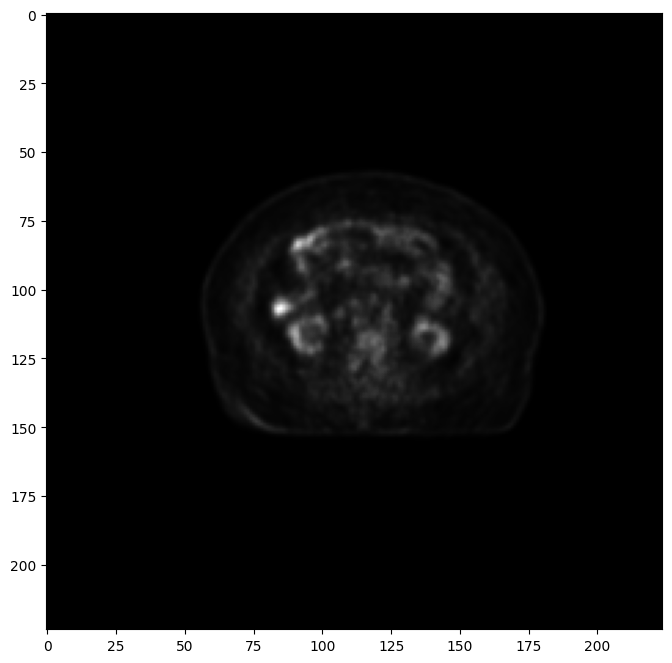

In [70]:
import numpy as np
import matplotlib.pyplot as plt
vol = np.load("./data/processed_CPTACUCEC_3D_pad/CT/C3L-00963/0.npy")
plt.figure(figsize=(8,8))
#vol = vol.transpose(0,2,1)
plt.imshow(volume["volume"][90,:,:], cmap='gray')

## Preprocess the WSI

In [3]:
dataset_path = os.path.normpath('./data/raw/Dataset5PatientsCPTAC/WSI/')
DIRNAMES = 1
annotations = pd.read_csv('./data/clinical_annotations.tsv', sep='\t')
wsi_ext = '.svs'
patch_size = [224,224]
threshold = 0.9 #tissue percentage per patch
max_patches = 16 #The number of patches we want per patient

#Get patients ids
patients_ids = get_patients_ids(dataset_path)
print(patients_ids)

#We get for each patient its corresponding year of diagnosis from the clinical annotations
patients_diagnosis_year = {}
for patient_id in patients_ids:
  patients_diagnosis_year[patient_id] = annotations.loc[annotations["case_submitter_id"] == patient_id]["year_of_diagnosis"].values[0]

#We create a dictionary that associates to each patient a dictionary composed of "date", "slide", "year_diff" that basically
#contains the nearest whole slide image to the diagnosis to be processed
best_wsi_dict = dict.fromkeys(patients_ids)
for path, _, files in sorted(os.walk(dataset_path)): 
    for filename in sorted(files):
      patient_id = filename.split('.')[0]
      patient_id = patient_id[:-3]
      #best_wsi_dict[patient_id]["diagnosis_year"] 
      slide = read_wsi(os.path.join(dataset_path,filename))
      
      comment = slide.properties["openslide.comment"].split("|")
      date = ""
      for x in comment:
        if "Date" in x:
          date = x.split(" = ")[1]
          date = datetime.strptime(date,'%m/%d/%y')
      
      if  best_wsi_dict[patient_id] is None or abs(date.year - int(patients_diagnosis_year[patient_id])) <= best_wsi_dict[patient_id]["year_diff"] and date > best_wsi_dict[patient_id]["date"]:
          best_wsi_dict[patient_id] = {
            "date": date,
            "slide": slide,
            "year_diff": abs(date.year - int(patients_diagnosis_year[patient_id]))
          }
print(best_wsi_dict)
#Given the selected whole slide images we preprocess them and generate the patches at level 1 since we empirically found that on average this is
#the typical level in which we calculate patches in this dataset.
for patient_id in patients_ids:
  slide = best_wsi_dict[patient_id]["slide"]
  best_patches = get_patches_at_level(slide, patch_size, threshold, max_patches, level = 1)
      
  #Save the patches in the right directory based on the cancer grade annotation
  cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
  output_path = './data/processed/WSI/'+cancer_grade+'/'+patient_id+'/'
  save_patches_as_numpy(best_patches, output_path, patient_id)       
      
        
      
"""
for path, _, files in sorted(os.walk(dataset_path)): 
      for filename in (sorted(files)): 
          if filename.endswith (wsi_ext):
            #Get the patient id
            patient_id = filename.split('.')[0]
            patient_id = patient_id[:-3]
            print(patient_id)
            #Search the wsi nearest to diagnosis
            
            #Load the wsi
            slide = read_wsi(os.path.join(dataset_path,filename))
            
            #Get the 16 patches from the wsi
            best_level, best_patches = find_best_level(slide, patch_size, threshold, max_patches)
            
            #Save the patches in the right directory based on the cancer grade annotation
            cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]
            output_path = './data/processed/WSI/'+cancer_grade+'/'+patient_id+'/'
            save_patches_as_numpy(best_patches, output_path, patient_id)

"""


{'C3L-00622', 'C3L-00189', 'C3L-00401', 'C3L-00625', 'C3L-00599'}
{'C3L-00622': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00622-21.svs'), 'year_diff': 0}, 'C3L-00189': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00189-21.svs'), 'year_diff': 1}, 'C3L-00401': {'date': datetime.datetime(2016, 11, 3, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00401-22.svs'), 'year_diff': 0}, 'C3L-00625': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00625-21.svs'), 'year_diff': 0}, 'C3L-00599': {'date': datetime.datetime(2017, 4, 11, 0, 0), 'slide': OpenSlide('data\\raw\\Dataset5PatientsCPTAC\\WSI\\C3L-00599-21.svs'), 'year_diff': 1}}


"\nfor path, _, files in sorted(os.walk(dataset_path)): \n      for filename in (sorted(files)): \n          if filename.endswith (wsi_ext):\n            #Get the patient id\n            patient_id = filename.split('.')[0]\n            patient_id = patient_id[:-3]\n            print(patient_id)\n            #Search the wsi nearest to diagnosis\n            \n            #Load the wsi\n            slide = read_wsi(os.path.join(dataset_path,filename))\n            \n            #Get the 16 patches from the wsi\n            best_level, best_patches = find_best_level(slide, patch_size, threshold, max_patches)\n            \n            #Save the patches in the right directory based on the cancer grade annotation\n            cancer_grade = annotations.loc[annotations['case_submitter_id'] == patient_id]['tumor_grade'].iloc[0]\n            output_path = './data/processed/WSI/'+cancer_grade+'/'+patient_id+'/'\n            save_patches_as_numpy(best_patches, output_path, patient_id)\n\n"

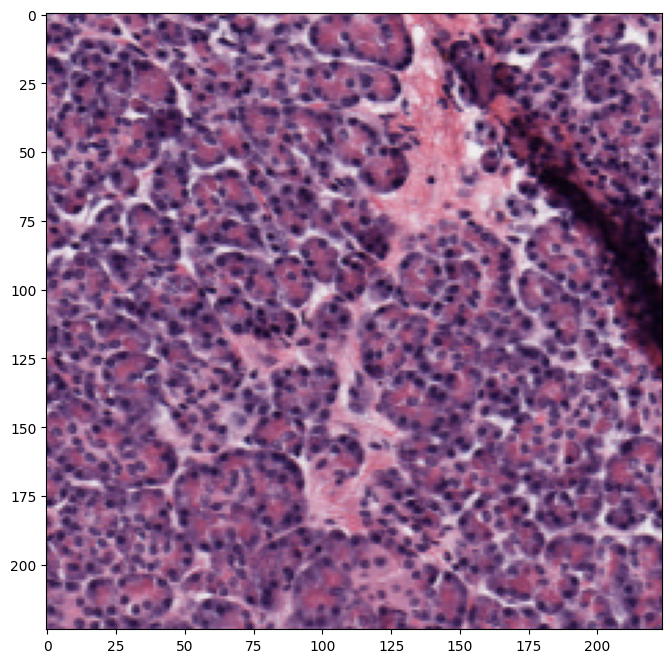

In [4]:
slide_thumb = np.load("./data/processed/WSI/G2/C3L-00625/patch_3.npy")
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb)

## Generate all, overfit, train, validation, test txt splits 

In [ ]:
#TODO 

---------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------

In [7]:
wsi = read_wsi("/home/users/pietro.caforio/thesis/CLAM/CPTAC_PDA/C3L-00017-21.svs")
print(wsi.properties)

<_PropertyMap {'aperio.AppMag': '20', 'aperio.DSR ID': 'aperio04', 'aperio.Date': '09/01/16', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': '99448', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '99448', 'aperio.Left': '41.217247', 'aperio.LineAreaXOffset': '0.023001', 'aperio.LineAreaYOffset': '-0.006920', 'aperio.LineCameraSkew': '0.001659', 'aperio.MPP': '0.4942', 'aperio.OriginalHeight': '21060', 'aperio.OriginalWidth': '20320', 'aperio.ScanScope ID': 'SS1553', 'aperio.StripeWidth': '2032', 'aperio.Time': '14:01:18', 'aperio.Time Zone': 'GMT-04:00', 'aperio.Top': '17.635538', 'aperio.User': '1d8dabbb-8c91-4d77-8fb4-add7735e561a', 'openslide.associated.label.height': '716', 'openslide.associated.label.width': '666', 'openslide.associated.macro.height': '629', 'openslide.associated.macro.width': '1600', 'openslide.associated.thumbnail.height': '768', 'openslide.associate

In [4]:
comment = wsi.properties["openslide.comment"].split("|")
date = ""
for x in comment:
    if "Date" in x:
        date = x.split(" = ")[1]
date

'04/11/17'

In [21]:
wsi.properties["openslide.comment"]

'14.366588'

In [17]:
print('\n'.join(wsi.properties))

aperio.AppMag
aperio.DSR ID
aperio.Date
aperio.DisplayColor
aperio.Exposure Scale
aperio.Exposure Time
aperio.Filename
aperio.Focus Offset
aperio.ICC Profile
aperio.ImageID
aperio.Left
aperio.LineAreaXOffset
aperio.LineAreaYOffset
aperio.LineCameraSkew
aperio.MPP
aperio.OriginalHeight
aperio.OriginalWidth
aperio.ScanScope ID
aperio.StripeWidth
aperio.Time
aperio.Time Zone
aperio.Top
aperio.User
openslide.associated.label.height
openslide.associated.label.width
openslide.associated.macro.height
openslide.associated.macro.width
openslide.associated.thumbnail.height
openslide.associated.thumbnail.width
openslide.comment
openslide.icc-size
openslide.level-count
openslide.level[0].downsample
openslide.level[0].height
openslide.level[0].tile-height
openslide.level[0].tile-width
openslide.level[0].width
openslide.level[1].downsample
openslide.level[1].height
openslide.level[1].tile-height
openslide.level[1].tile-width
openslide.level[1].width
openslide.level[2].downsample
openslide.level[2].h

In [24]:
from datetime import datetime

In [25]:
date = datetime.strptime(date,'%m/%d/%y')

In [29]:
date.year

2017

In [10]:
import cptac

In [12]:
pda = cptac.Pdac()

In [13]:
ucec = cptac.Ucec()

In [16]:
ucec.list_data_sources()

,Data type,Available sources
0,CNV,"[bcm, washu]"
1,circular_RNA,[bcm]
2,miRNA,"[bcm, washu]"
3,phosphoproteomics,"[bcm, umich]"
4,proteomics,"[bcm, umich]"
5,transcriptomics,"[bcm, broad, washu]"
6,ancestry_prediction,[harmonized]
7,somatic_mutation,"[harmonized, washu]"
8,clinical,[mssm]
9,follow-up,[mssm]


In [6]:
import pydicom as dicom
#dicom.dcmread("./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA/C3L-00189/07-28-2003-NA-CT ABDOMEN  PELVIS ENHANCEDAB-63347/2.000000-AP C 5mm-39510/1-001.dcm")
#dicom.dcmread("./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA/C3L-00189/07-28-2003-NA-CT ABDOMEN  PELVIS ENHANCEDAB-63347/302.000000-LUNG BASES 5MM-26037/1-01.dcm")
dicom.dcmread("./data/raw/Dataset57PatientsCPTACPDA/manifest-1720346699071/CPTAC-PDA/C3L-00189/07-28-2003-NA-CT ABDOMEN  PELVIS ENHANCEDAB-63347/303.000000-AP 52.5MM 20 ASIR-64593/1-001.dcm")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1078.3273.967009796405911576915211771611
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20030728'
(0008, 0013) Instance Creation Time              TM: '145741'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Insta